#### 계층적 군집화(hierachical clustering)는 여러개의 군집 중에서 가장 유사도가 높은 혹은 거리가 가까운 군집 두 개를 선택하여 하나로 합치면서 군집 개수를 줄여 가는 방법을 말한다. 가장 처음에는 모든 군집이 하나의 데이터만을 가진다. 따라서 최초에는 데이터 개수만큼 군집이 존재하지만 군집을 합치면서 최종적으로 하나의 군집만 남게 된다.

In [1]:
from keras.datasets import mnist
import numpy as np
import pandas as pd
import os, time
import pickle, gzip

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [2]:
download_root = 'MNIST_data/'

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [4]:
X_validation = X_train[50000:]
y_validation = y_train[50000:]
X_train = X_train[:50000]
y_train = y_train[:50000]
X_train = X_train.reshape(-1,28*28)
X_validation = X_validation.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)

In [5]:
train_index = range(0, len(X_train))
validation_index = range(len(X_train), len(X_train)+len(X_validation))
test_index = range(len(X_train)+len(X_validation), len(X_train)+len(X_validation)+len(X_test))

X_train = pd.DataFrame(data = X_train, index = train_index)
y_train = pd.Series(data = y_train, index=train_index)

X_validation = pd.DataFrame(data=X_validation, index=validation_index)
y_validation = pd.Series(data=y_validation, index=validation_index)

X_test = pd.DataFrame(data=X_test, index=test_index)
y_test = pd.Series(data=y_test, index=test_index)

In [6]:
from sklearn.decomposition import PCA

n_components = 784
whiten = False
random_state=2018

pca = PCA(n_components=n_components, whiten=whiten, random_state=random_state)

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=train_index)

- Ward's minimum variance method(https://en.wikipedia.org/wiki/Ward's_method)

### fastcluster 계층적 클러스터링 사용

In [9]:
import fastcluster
from scipy.cluster.hierarchy import dendrogram, cophenet
from scipy.spatial.distance import pdist

cutoff = 99
Z = fastcluster.linkage_vector(X_train_PCA.loc[:, 0:cutoff], method='ward', metric='euclidean')
Z_dataFrame = pd.DataFrame(data=Z, columns=['clusterOne', 'clusterTwo', 'distance','newClusterSize'])

- 행렬 Z를 반환
- 50000개 MNIST 데이터셋의 각 관측치를 단일 포인트 군집으로 처리하고 각 반복 훈련마다 최소 거리를 가진 두 군집을 병합한다. 

In [10]:
Z_dataFrame[:20]

,clusterOne,clusterTwo,distance,newClusterSize
0,42194.0,43025.0,144.046690,2.0
1,28350.0,37674.0,151.261716,2.0
2,26696.0,44705.0,159.105543,2.0
3,12634.0,32823.0,160.706973,2.0
4,24707.0,43151.0,163.242960,2.0
5,20465.0,24483.0,169.614567,2.0
6,466.0,42098.0,170.032414,2.0
7,46542.0,49961.0,170.373039,2.0
8,2301.0,5732.0,171.831144,2.0
9,37564.0,47668.0,172.831073,2.0


In [42]:
Z_dataFrame[49980:]

,clusterOne,clusterTwo,distance,newClusterSize
49980,99965.0,99972.0,41243.391562,5197.0
49981,99932.0,99980.0,44049.920836,6505.0
49982,99945.0,99960.0,46807.260059,3245.0
49983,99964.0,99976.0,47225.794701,3683.0
49984,99974.0,99979.0,47367.128897,7744.0
49985,99940.0,99975.0,47448.372962,5596.0
49986,99957.0,99967.0,54234.806771,5957.0
49987,99938.0,99983.0,55166.683285,4846.0
49988,99978.0,99984.0,55490.653402,11072.0
49989,99970.0,99973.0,55643.103011,4899.0


- 거리가 단조롭게 증가
- 최단 거리 군집이 먼저 병합되고 모든 점이 덴드로그램 가장 위에 있는 단일 군집으로 결합될 때까지 다음 최단 거리 군집을 반복적으로 병합

### 클러스터링 결과 평가하기

- 20개의 군집을 갖도록 덴드로그램을 자름
- 덴드로그램의 거리 임계값을 설정해 개별 군집을 얼마나 많이 남겨야 하는지 결정해야 한다.
- 거리 임곗값이 클수록 군집 수는 줄어든다.
- fcluster 라이브러리는 우리가 지정한 거리 임곗값으로 덴드로그램을 잘라낸다.

In [40]:
from scipy.cluster.hierarchy import fcluster

distance_threshold = 41000
clusters = fcluster(Z, distance_threshold, criterion = 'distance')
X_train_hierClustered = pd.DataFrame(data = clusters, index = X_train_PCA.index, columns=['cluster'])

In [41]:
print("Number of distinct clusters: ", len(X_train_hierClustered['cluster'].unique()))

Number of distinct clusters:  20


In [44]:
def analyzeCluster(clusterDF, labelsDF):
    countByCluster = pd.DataFrame(data=clusterDF['cluster'].value_counts())
    countByCluster.reset_index(inplace=True, drop=False)
    countByCluster.columns = ['cluster', 'clusterCount']
    
    preds = pd.concat([labelsDF, clusterDF], axis=1)
    preds.columns = ['trueLabel', 'cluster']
    
    countByLabel = pd.DataFrame(data=preds.groupby('trueLabel').count())
    
    countMostFreq = pd.DataFrame(data=preds.groupby('cluster').agg(lambda x:x.value_counts().iloc[0])) # 가장 자주 발생하는 숫자의 개수
    countMostFreq.reset_index(inplace=True, drop=False)
    countMostFreq.columns = ['cluster', 'countMostFrequent']
    
    # 군집의 전체 정확도
    accuracyDF = countMostFreq.merge(countByCluster, left_on="cluster", right_on = "cluster")
    overallAccuracy = accuracyDF.countMostFrequent.sum()/accuracyDF.clusterCount.sum()
    # 모든 군집별로 가장 자주 발생하는 관측치 개수 합을 훈련셋의 총 관측치 개수로 나눈 값
    
    accuracyByLabel = accuracyDF.countMostFrequent/accuracyDF.clusterCount
    
    return countByCluster, countByLabel, countMostFreq, accuracyDF, overallAccuracy, accuracyByLabel

In [45]:
countByCluster_hierClust, countByLabel_hierClust, countMostFreq_hierClust,\
accuracyDF_hierClust, overallAccuracy_hierClust, accuracyByLabel_hierClust = analyzeCluster(X_train_hierClustered, y_train)

print("Overall accuracy from hierarchical clustering: ", overallAccuracy_hierClust)

Overall accuracy from hierarchical clustering:  0.76882


In [46]:
# 군집별 정확도 평가
accuracyByLabel_hierClust

0     0.987962
1     0.983727
2     0.988998
3     0.597356
4     0.678642
5     0.442478
6     0.950033
7     0.829060
8     0.976062
9     0.986141
10    0.990183
11    0.992183
12    0.971033
13    0.554273
14    0.553617
15    0.720183
16    0.538891
17    0.484590
18    0.957732
19    0.977310
dtype: float64

### 사이파이 패키지의 linkage 명령 사용

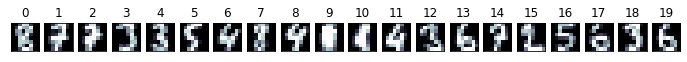

In [48]:
from sklearn.datasets import load_digits

digits = load_digits()
n_image = 20
np.random.seed(0)
idx = np.random.choice(range(len(digits.images)), n_image)
X = digits.data[idx]
images = digits.images[idx]

plt.figure(figsize=(12,1))
for i in range(n_image):
    plt.subplot(1, n_image, i+1)
    plt.imshow(images[i], cmap=plt.cm.bone)
    plt.grid(False)
    plt.xticks(())
    plt.yticks(())
    plt.title(i)

In [49]:
from scipy.cluster.hierarchy import linkage, dendrogram

Z = linkage(X, 'ward')
Z

array([[ 3.        , 18.        , 23.51595203,  2.        ],
       [13.        , 19.        , 25.27844932,  2.        ],
       [ 1.        , 14.        , 28.67054237,  2.        ],
       [17.        , 21.        , 31.04298096,  3.        ],
       [ 4.        ,  7.        , 31.51190251,  2.        ],
       [ 6.        ,  8.        , 32.54228019,  2.        ],
       [ 9.        , 10.        , 33.36165464,  2.        ],
       [ 0.        , 24.        , 34.51086785,  3.        ],
       [ 2.        , 22.        , 37.03151811,  3.        ],
       [11.        , 26.        , 43.25505751,  3.        ],
       [12.        , 15.        , 45.31004304,  2.        ],
       [16.        , 20.        , 45.36151085,  3.        ],
       [ 5.        , 27.        , 53.54437412,  4.        ],
       [30.        , 32.        , 56.6892112 ,  6.        ],
       [25.        , 29.        , 60.16809786,  5.        ],
       [28.        , 34.        , 66.61618922,  8.        ],
       [31.        , 33.

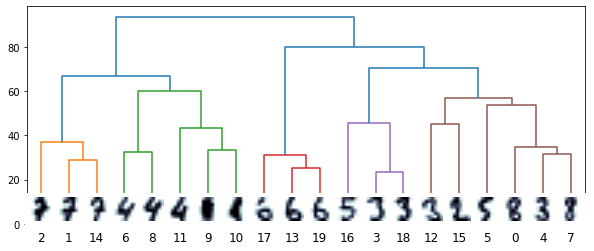

In [51]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

plt.figure(figsize=(10, 4))
ax = plt.subplot()

ddata = dendrogram(Z)

dcoord = np.array(ddata["dcoord"])
icoord = np.array(ddata["icoord"])
leaves = np.array(ddata["leaves"])
idx = np.argsort(dcoord[:, 2])
dcoord = dcoord[idx, :]
icoord = icoord[idx, :]
idx = np.argsort(Z[:, :2].ravel())
label_pos = icoord[:, 1:3].ravel()[idx][:20]

for i in range(20):
    imagebox = OffsetImage(images[i], cmap=plt.cm.bone_r, interpolation = "bilinear", zoom=3)
    ab = AnnotationBbox(imagebox, (label_pos[i], 0), box_alignment=(0.5, -0.1),
                       bboxprops = {"edgecolor" : "none"})
    ax.add_artist(ab)
    
plt.show()